In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys
sys.path.insert(0, "../fairseq")
sys.path.insert(0, "../")
sys.path.insert(0, "~/utility/imputer-pytorch")
# %load_ext autoreload
# %autoreload 2

In [3]:
# https://github.com/pytorch/fairseq/blob/master/fairseq_cli/generate.py

In [25]:
from fairseq import (
    checkpoint_utils,
    options,
    quantization_utils,
    tasks,
    utils,
)
from torchinfo import summary
import logging
import os
import matplotlib.pyplot as plt
import torch
from torch_imputer import best_alignment
from simultaneous_translation.modules.sinkhorn_attention import (
    gumbel_sinkhorn
)

In [5]:
checkpoint="../exp/checkpoints/toy_mt_proj/checkpoint_best.pt"
inference_config_yaml="../exp/infer_mt.yaml"
use_cuda = False

states = checkpoint_utils.load_checkpoint_to_cpu(
    path=checkpoint, arg_overrides=None, load_on_all_ranks=False)
cfg = states["cfg"]
cfg.task.inference_config_yaml = inference_config_yaml

In [6]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=os.environ.get("LOGLEVEL", "INFO").upper(),
    stream=sys.stdout,
)
logger = logging.getLogger("fairseq_cli.train")

In [7]:
utils.import_user_module(cfg.common)

# Setup task, e.g., translation, language modeling, etc.
task = tasks.setup_task(cfg.task)
# Build model and criterion
model = task.build_model(cfg.model)
criterion = task.build_criterion(cfg.criterion)
logger.info(summary(model))
logger.info("task: {}".format(task.__class__.__name__))
logger.info("model: {}".format(model.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))

2021-06-03 15:49:13 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-06-03 15:49:13 | INFO | fairseq.tasks.translation | [es] dictionary: 8000 types
2021-06-03 15:49:14 | INFO | simultaneous_translation.criterion.label_smoothed_ctc_criterion | Using ctc loss for decoder!
2021-06-03 15:49:14 | INFO | fairseq_cli.train | ================================================================================
Layer (type:depth-idx)                                  Param #
ToySinkhornEncoderModel                                 --
├─SinkhornCascadedEncoder: 1-1                          --
│    └─CausalTransformerEncoder: 2-1                    --
│    │    └─FairseqDropout: 3-1                         --
│    │    └─Embedding: 3-2                              2,048,000
│    │    └─SinusoidalPositionalEmbedding: 3-3          --
│    │    └─ModuleList: 3-4                             7,890,432
│    │    └─FusedLayerNorm: 3-5                         512
│    └─ModuleList: 2-2    

In [8]:
logger.info("loading model(s) from {}".format(cfg.common_eval.path))
model = task.build_model(cfg.model)
model.load_state_dict(
    states["model"], strict=True, model_cfg=cfg.model
)

# Optimize ensemble for generation
use_fp16 = False
if use_cuda:
    if torch.cuda.get_device_capability(0)[0] >= 7:
        model.half()
        use_fp16 = True
    model.cuda()
model.prepare_for_inference_(cfg)

2021-06-03 15:49:14 | INFO | fairseq_cli.train | loading model(s) from None


In [9]:
task.load_dataset(cfg.dataset.gen_subset, task_cfg=cfg.task)

2021-06-03 15:49:14 | INFO | fairseq.data.data_utils | loaded 260,049 examples from: /media/george/Data/mustc/en-es/mt/data-bin/test.en-es.en
2021-06-03 15:49:14 | INFO | fairseq.data.data_utils | loaded 260,049 examples from: /media/george/Data/mustc/en-es/mt/data-bin/test.en-es.es
2021-06-03 15:49:14 | INFO | fairseq.tasks.translation | /media/george/Data/mustc/en-es/mt/data-bin test en-es 260049 examples


In [10]:
# Load dataset 
itr = task.get_batch_iterator(
    dataset=task.dataset(cfg.dataset.gen_subset),
    max_tokens=cfg.dataset.max_tokens,
    max_sentences=cfg.dataset.batch_size,
    max_positions=utils.resolve_max_positions(
        task.max_positions(), model.max_positions() #*[m.max_positions() for m in models]
    ),
    ignore_invalid_inputs=cfg.dataset.skip_invalid_size_inputs_valid_test,
    required_batch_size_multiple=cfg.dataset.required_batch_size_multiple,
    seed=cfg.common.seed,
    num_shards=cfg.distributed_training.distributed_world_size,
    shard_id=cfg.distributed_training.distributed_rank,
    num_workers=cfg.dataset.num_workers,
    data_buffer_size=cfg.dataset.data_buffer_size,
).next_epoch_itr(shuffle=False)

generator = task.build_generator(
    [model], cfg.generation, extra_gen_cls_kwargs=None
)

# Handle tokenization and BPE
def decode(
    tensor,
    escape_unk=False,
    unk_string=None,
    include_eos=False,
    separator=None,
):    
    def token_string(i):
        if i == task.tgt_dict.unk():
            if unk_string is not None:
                return unk_string
            else:
                return task.tgt_dict.unk_string(escape_unk)
        else:
            return task.tgt_dict[i]

    sent = [token_string(i) for i in tensor]
    return sent if separator is None else separator.join(sent)

In [11]:
def apply_half(t):
    if t.dtype is torch.float32:
        return t.half()
    return t

skips = 10
for i,sample in enumerate(itr):
    if use_cuda:
        sample = utils.move_to_cuda(sample) 
        if use_fp16:
            sample = utils.apply_to_sample(apply_half, sample)
    if "net_input" not in sample or i<skips:
        continue

    break

src_tokens = sample["net_input"]["src_tokens"]
src_lengths = sample["net_input"]["src_lengths"]
target = sample["target"]
logits, extra = model.forward(src_tokens, src_lengths, return_all_hiddens=True)
pred_argmax = logits.argmax(-1)
[decode(t) for t in src_tokens][:10]

[['▁♫', '▁Maybe', '▁hum', 'm', 'ing', '▁along', '▁♫', '</s>'],
 ['▁Just', '▁let', 'ting', '▁you', '▁know', '▁', '.', '</s>'],
 ['▁I', '▁became', '▁a', '▁cartoon', 'ist', '▁', '.', '</s>'],
 ['▁It', "▁'", 's', '▁too', '▁cold', '▁', '.', '</s>'],
 ['▁I', "▁'", 'm', '▁an', '▁individual', '▁', '.', '</s>'],
 ['▁I', '▁had', '▁so', '▁much', '▁fun', '▁', '.', '</s>'],
 ['▁Can', "▁'", 't', '▁you', '▁see', '▁', '?', '</s>'],
 ['▁I', '▁met', '▁my', '▁host', '▁family', '▁', '.', '</s>'],
 ['▁You', '▁would', '▁not', '▁believe', '▁it', '▁', '!', '</s>'],
 ['▁(', '▁Wo', 'man', '▁scream', 'ing', '▁', ')', '</s>']]

In [12]:
if use_cuda:
    net_output = (logits, extra)
    lprobs = model.get_normalized_probs(
        net_output, log_probs=True
    )
    bsz = target.size(0)
    max_src = lprobs.size(1)
    lprobs = lprobs.transpose(1, 0).contiguous()

    # get subsampling padding mask & lengths
    if net_output[1]["padding_mask"] is not None:
        non_padding_mask = ~net_output[1]["padding_mask"]
        input_lengths = non_padding_mask.long().sum(-1)
    else:
        input_lengths = lprobs.new_ones(
            (bsz, max_src), dtype=torch.long).sum(-1)

    pad_mask = (target != task.tgt_dict.pad()) & (
        target != task.tgt_dict.eos()
    )
    targets_flat = target.masked_select(pad_mask)
    target_lengths = pad_mask.long().sum(-1)

    forced_states = best_alignment(
        lprobs, target, input_lengths, target_lengths, blank=0, zero_infinity=False
    )
    pred_forced = [
        [0 if state % 2 == 0 else sent[state // 2] for state in states]
        for states, sent in zip(forced_states, target)
    ]
else:
    pred_forced = pred_argmax

In [13]:
from typing import Optional, Callable

def plot_align(
    aln,
    titles: Optional[list]=None,
    x_tokens: Optional[list]=None,
    y_tokens: Optional[list]=None,
    norm_fn: Optional[Callable]=lambda x:x,
    columns: Optional[int]=1,
    tick_size: Optional[int]=10,
    fig_size: Optional[tuple]=(12,8),
    save: Optional[str]=None,
    cmap=plt.cm.viridis #plt.cm.Blues,
):
    """Function to plot the alignment with tokens
    """
    
    n_graphs = len(aln)
    rows = 1+(n_graphs // columns)
    ylen, xlen = aln[0].shape
    
    if titles is None:
        titles = [f"example {i}" for i in range(n_graphs)]
    if x_tokens is None:
        x_tokens = [range(xlen)]*n_graphs
    if y_tokens is None:
        y_tokens = [range(ylen)]*n_graphs    
    
    fig = plt.figure(figsize=(fig_size[0]*columns,fig_size[1]*rows), dpi=100) 
    for i,a in enumerate(aln):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(norm_fn(a), cmap=cmap)
        ax.set_title(titles[i%len(titles)]) # title
        for tick in ax.get_xticklabels(): # diagonal xtick
            tick.set_rotation(45)
        ax.set_xticks(range(xlen)) 
        ax.set_xticklabels(x_tokens[i%len(x_tokens)], fontsize=tick_size)
        ax.set_yticks(range(ylen)) 
        ax.set_yticklabels(y_tokens[i%len(y_tokens)], fontsize=tick_size)
     
    if save is not None:
        fig.savefig(save)

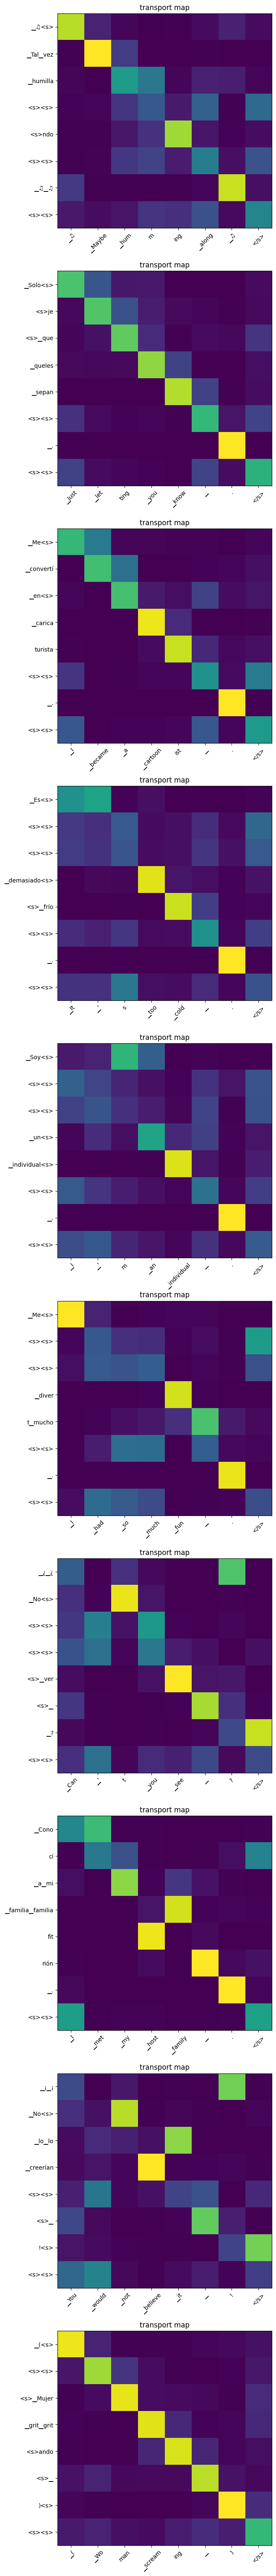

In [26]:
N = 10

x_tokens = [decode(t) for t in src_tokens[:N]]
y_tokens = [decode(t) for t in pred_forced[:N]]
y_tokens = [
    [l+r for l, r in zip(sent[::2], sent[1::2])]
    for sent in y_tokens]

attn_weights = extra["attn"][0].data.float().cpu()
log_alpha = extra["log_alpha"][0].data.float().cpu()
b, n = attn_weights.shape[:2]
plot_align(
    attn_weights[:N],
#     fig_size=(13,13),
    x_tokens=x_tokens,
    y_tokens=y_tokens,
    titles = ["transport map"],
)

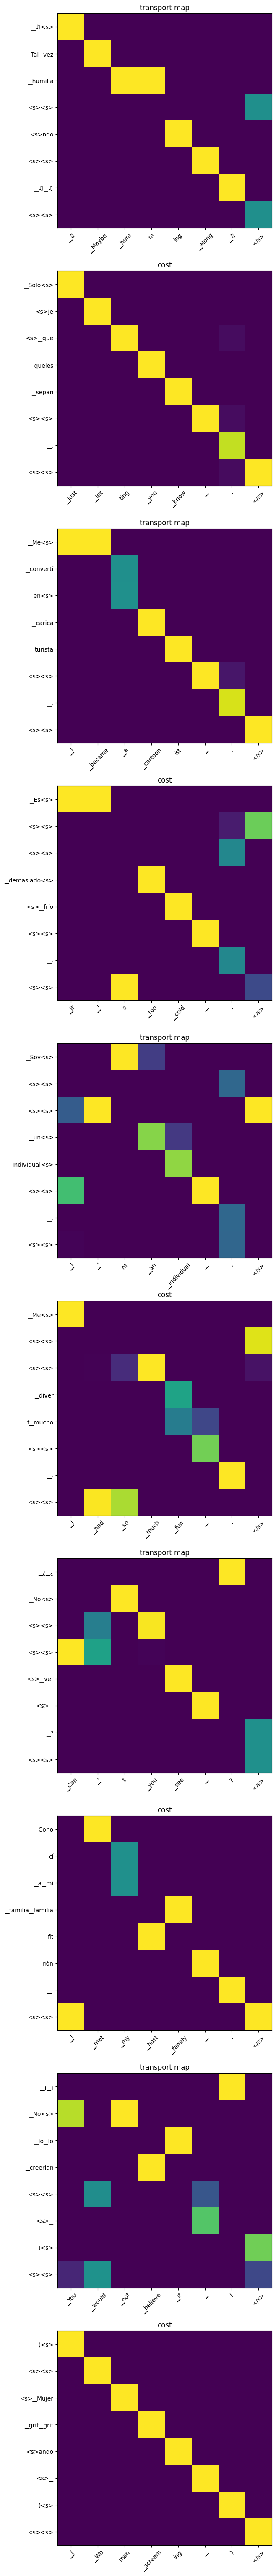

In [27]:
attn_weights = gumbel_sinkhorn(
    log_alpha,
    tau=0.02,
    n_iter=8,
    noise_factor=0.
)
plot_align(
    attn_weights[:N],
#     fig_size=(13,13),
    x_tokens=x_tokens,
    y_tokens=y_tokens,
    titles = ["transport map", "cost"],
)

In [ ]:
def real_sinkhorn(log_alpha: torch.Tensor, tau: float = 0.7, n_iter: int = 20, noise: bool = True):
    """
    https://github.com/gpeyre/SinkhornAutoDiff/blob/master/sinkhorn_pointcloud.py
    """
    b, _, n = log_alpha.size()
    mu = log_alpha.new_ones((b, n)) / n
    nu = log_alpha.new_ones((b, n)) / n
    epsilon = tau
    C = -log_alpha
    
    # Parameters of the Sinkhorn algorithm.
    rho = 1  # (.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / epsilon

    def lse(A, dim):
        "log-sum-exp"
        return torch.logsumexp(A, dim, keepdim=True)
        #return torch.log(torch.exp(A).sum(1, keepdim=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(n_iter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v), -1).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v), -2).squeeze()) + v
        # accelerated unbalanced iterations
        # u = ave( u, lam * ( epsilon * ( torch.log(mu) - lse(M(u,v)).squeeze()   ) + u ) )
        # v = ave( v, lam * ( epsilon * ( torch.log(nu) - lse(M(u,v).t()).squeeze() ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    return pi